# Load data

In [1]:
import pandas as pd 
data = {
    'train' : None
    #'val' : None,
    #'test' : None
}
for df_name in data.keys():
    data[df_name] = pd.read_csv(f"final_dataset/{df_name}.csv")

In [2]:
data['train'].head()

,note,contenu,sentiment
0,3.5,"Malgré le fait que ""Les Minions 2"" soit un fil...",1
1,0.5,Vous voyez le film 50 Nuances de Grey ? Si vou...,0
2,5.0,"J'ai littéralement adoré ce film, il y a beauc...",1
3,3.0,L'histoire est complètement folle... comme l'u...,1
4,0.5,Que retenir de ce troisième volet des BAD BOYS...,0


# Custom vocab and tokenization

**Idée :**
Utilisation de tokenizer déjà existant (spacy `fr_core_news_sm`) pour:
- Enlever les stop words.
- Enlever la ponctuation
- Enlever les NER (`Personne`, `Loc`, `Org`, `Date` etc..).
- garder le lemma et pas le mot brut pour mieux géneraliser 

In [3]:
sample_data = [data['train']['contenu'].iloc[i] for i in range(10)]

## Load spacy model

In [4]:
import spacy
nlp = spacy.load("fr_core_news_sm")

## First test

In [5]:
doc = nlp(sample_data[0])

for token in doc:
    print(token.text, token.lemma_,  token.pos_, token.is_stop)

Malgré malgré ADP True
le le DET True
fait fait NOUN True
que que SCONJ True
" " PUNCT False
Les le DET True
Minions minion NOUN False
2 2 NUM False
" " PUNCT False
soit soit ADV True
un un DET True
film film NOUN False
sympathique sympathique ADJ False
à à ADP True
regarder regarder VERB False
, , PUNCT False
il il PRON True
n' ne ADV True
arrive arriver VERB False
malheureusement malheureusement ADV False
pas pas ADV True
au au ADP True
niveau niveau NOUN False
des de ADP True
premiers premier ADJ False
films film NOUN False
" " PUNCT False
Moi Moi PROPN True
, , PUNCT False
Moche Moche PROPN False
et et CCONJ True
Méchant méchant ADJ False
" " PUNCT False
/ / CCONJ False
" " PUNCT False
Les le DET True
Minions Minions PROPN False
" " PUNCT False
, , PUNCT False
sans sans ADP True
que que SCONJ True
ce ce PRON True
soit être AUX True
un un DET True
mauvais mauvais NOUN False
divertissement divertissemer VERB False
non non ADV False
plus plus ADV True
. . PUNCT False
Je je PRON True
m

In [6]:
# Print named entities with token positions
for ent in doc.ents:
    print(f"Entity: '{ent.text}' | Label: {ent.label_} | Start Token: {ent.start} | End Token: {ent.end}")


Entity: 'Minions 2' | Label: MISC | Start Token: 6 | End Token: 8
Entity: 'Moi, Moche et Méchant' | Label: MISC | Start Token: 27 | End Token: 32
Entity: 'Minions' | Label: LOC | Start Token: 36 | End Token: 37


In [7]:
# test 
def preprocess(text : str)->str:
    text = str(text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    # first on remove les NER
    for ent in doc.ents:
        for i in range(ent.end-ent.start):
            tokens[i+ent.start] = False

    # après la ponctuation et les stop_words
    for i, token in enumerate(doc):
        if token.is_stop or token.pos_ == 'PUNCT':
            tokens[i] = False 
        elif token.lemma_== '/': # CCONJ mais pas stop word
            tokens[i] = False

    tokens = [tokens[i] for i in range(len(tokens)) if tokens[i] != False]
    return " ".join(tokens)
print('text before :', sample_data[0])
new_text = preprocess(sample_data[0])
print('new tokens :', new_text)

text before : Malgré le fait que "Les Minions 2" soit un film sympathique à regarder, il n'arrive malheureusement pas au niveau des premiers films "Moi, Moche et Méchant" / "Les Minions", sans que ce soit un mauvais divertissement non plus. Je m'explique.Pour commencer, il fait sourire, rire par moment mais pas autant que les films précédents. Cela se constate notamment dans la salle de cinéma : les adultes et les enfants étaient plus rieurs lors des séances de diffusion des premiers films. De plus, la réalisation a parfois eu la volonté de pousser l'absurdité un peu trop loin. En effet, certaines scènes sont tellement absurdes (notamment avec l'avion) que ça en devient un peu gênant.. mais cela reste drôle quand même.Enfin, il y a des incohérences, des facilités scénaristiques ainsi que de longues périodes de dialogues/monologues de minions qui deviennent parfois assez agaçants à suivre.Je n'ai personnellement rien à dire par rapport au scénario : il est classique mais sympathique.. e

## Suppression des mots useless

### Idée sur un sample

On travaille ici sur un sample de train car l'application de l'idée est très couteuse !

In [8]:
# at this point check top words
from collections import Counter
# create a sample to avoid long time
df = data['train'][:500].copy()
df.head()


,note,contenu,sentiment
0,3.5,"Malgré le fait que ""Les Minions 2"" soit un fil...",1
1,0.5,Vous voyez le film 50 Nuances de Grey ? Si vou...,0
2,5.0,"J'ai littéralement adoré ce film, il y a beauc...",1
3,3.0,L'histoire est complètement folle... comme l'u...,1
4,0.5,Que retenir de ce troisième volet des BAD BOYS...,0


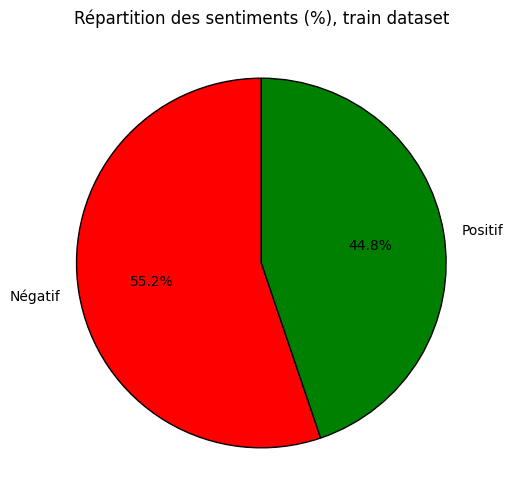

In [9]:
import matplotlib.pyplot as plt
# Calculer la distribution des sentiments
sentiment_counts = df["sentiment"].value_counts(normalize=True) * 100  # Convertir en pourcentage

# Création du camembert (pie chart)
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts, 
    labels=["Négatif", "Positif"], 
    autopct="%1.1f%%",  # Affichage des pourcentages avec 1 décimale
    colors=["red", "green"],  # Couleurs : rouge pour négatif, vert pour positif
    startangle=90,  # Commencer à 90° pour un meilleur visuel
    wedgeprops={"edgecolor": "black"}  # Bordures noires pour améliorer la lisibilité
)

# Ajouter un titre
plt.title("Répartition des sentiments (%), train dataset")

# Afficher le graphique
plt.show()

the sample follows the same distrbution as global train dataset.

In [10]:
df['cleaned_contenu'] = df['contenu'].map(preprocess) # prend du temps

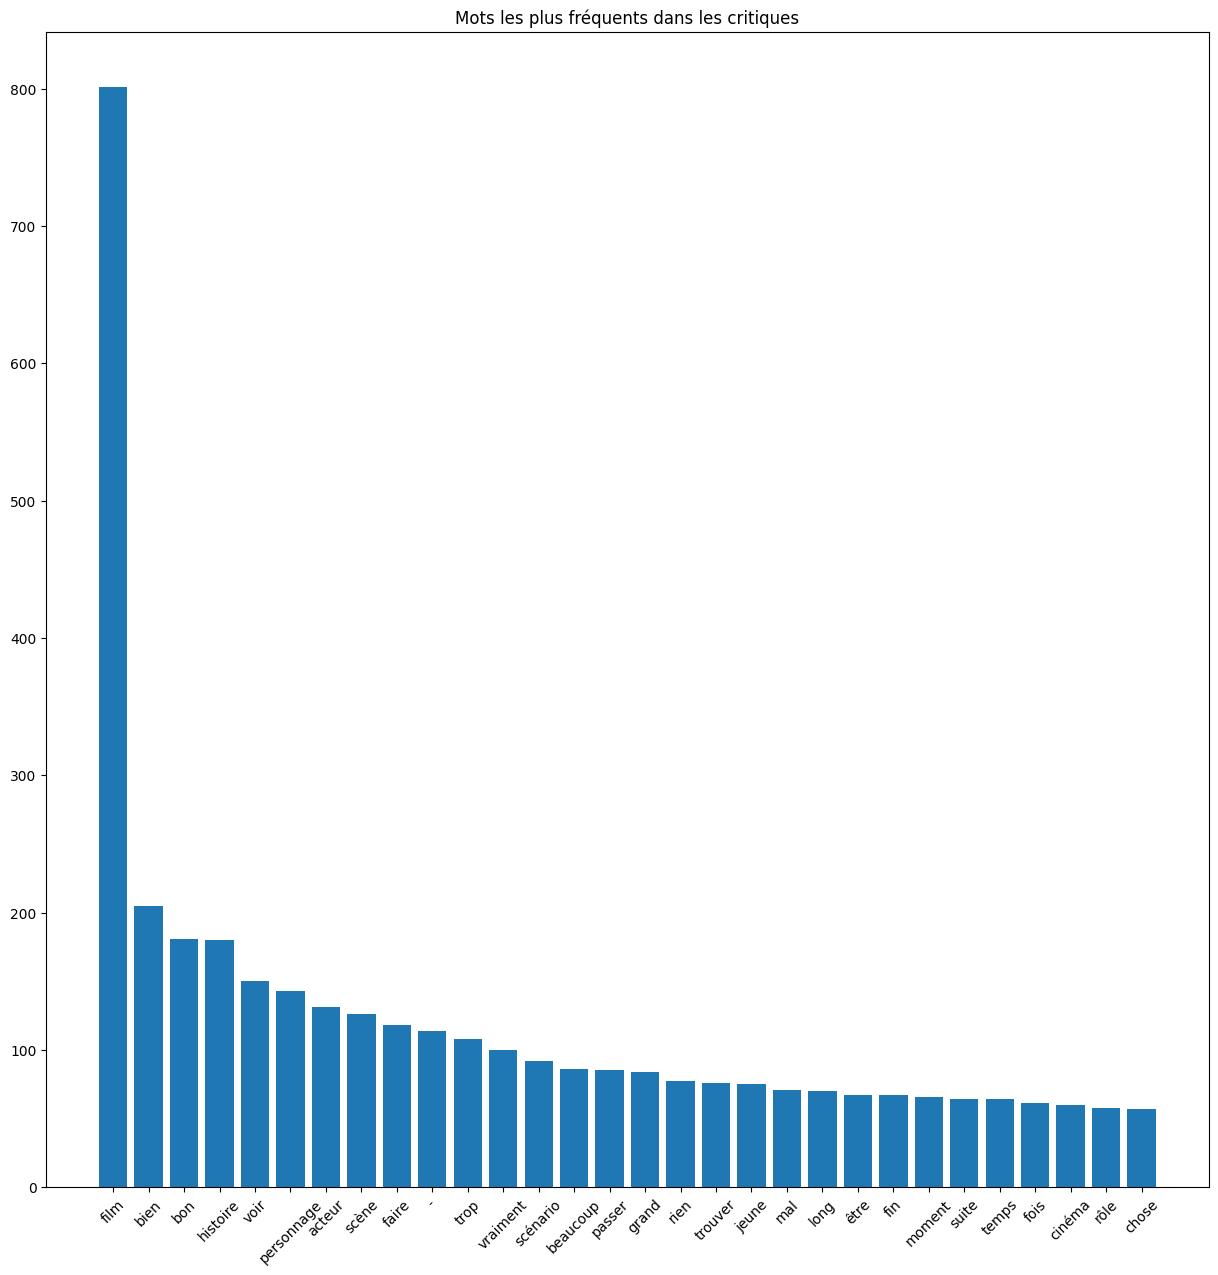

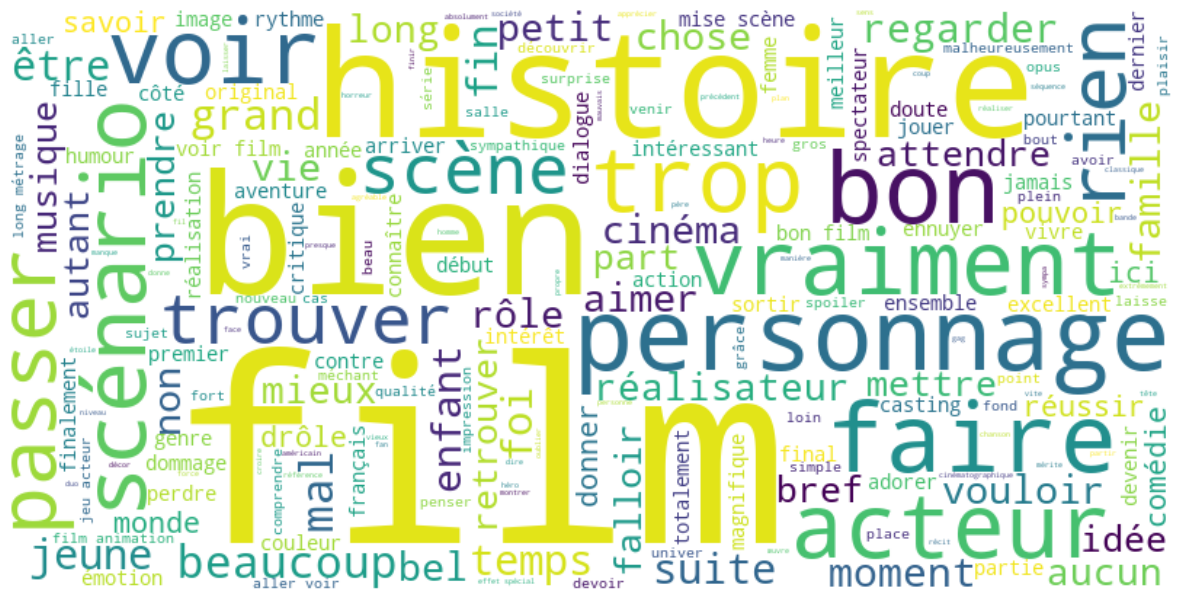

In [11]:
from wordcloud import WordCloud
def lower(text):
    return text.lower()

all_words = " ".join(df['cleaned_contenu'].map(lower)).split()
word_freq = Counter(all_words)
# Affichage des mots les plus fréquents
most_common_words = word_freq.most_common(30)
words, counts = zip(*most_common_words)
plt.figure(figsize=(15, 15))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Mots les plus fréquents dans les critiques")
plt.show()

# Génération d'un WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Avec cette visualisation, on récupère les mots communs. Certains de ces mots semblent factuels et ont potentiellement aucun impact sur le sentiment final (`TF-IDF` ne prend pas en compte le contexte).

**Idée :**  
- Vérifier les mots les plus fréquents qui ont peu d'impact sur le sentiment final.  
- Si c'est le cas, nous les supprimerons lors du prétraitement.  

In [12]:
from tqdm import tqdm
def wordBalancedOnSentiment(word_freq :list, df : pd.DataFrame, top=None):
    words_count = {} 
    for j in tqdm(range(df.shape[0])):
        words = df['cleaned_contenu'].iloc[j].lower().split() # the already preprocess one 
        for word in words:
            if word not in words_count:
                words_count[word] = [0 for _ in range(df.shape[0])]
            words_count[word][j] += 1

    if not top:  
        words_count['__sentiment__'] = df['sentiment'].copy()
        return pd.DataFrame(words_count)
    
    new_words_count = {'__sentiment__' : df['sentiment'].copy()}
    stop_range = min(len(word_freq), top) 
    for i in tqdm(range(stop_range)):
        word = word_freq[i][0]
        new_words_count[word] = words_count[word]
    return pd.DataFrame(new_words_count)

In [13]:
df_words = wordBalancedOnSentiment(list(word_freq.items()), df, 30)
df_words.head()

100%|██████████| 30/30 [00:00<?, ?it/s]


,__sentiment__,film,sympathique,regarder,arriver,malheureusement,niveau,premier,mauvais,divertissemer,...,adulte,enfant,rieur,séance,diffusion,réalisation,volonté,pousser,absurdité,trop
0,1,8,2,2,1,1,2,2,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\matte\AppData\Local\Temp\ipykernel_7076\2819194132.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.index, y=corr.values, palette="coolwarm")


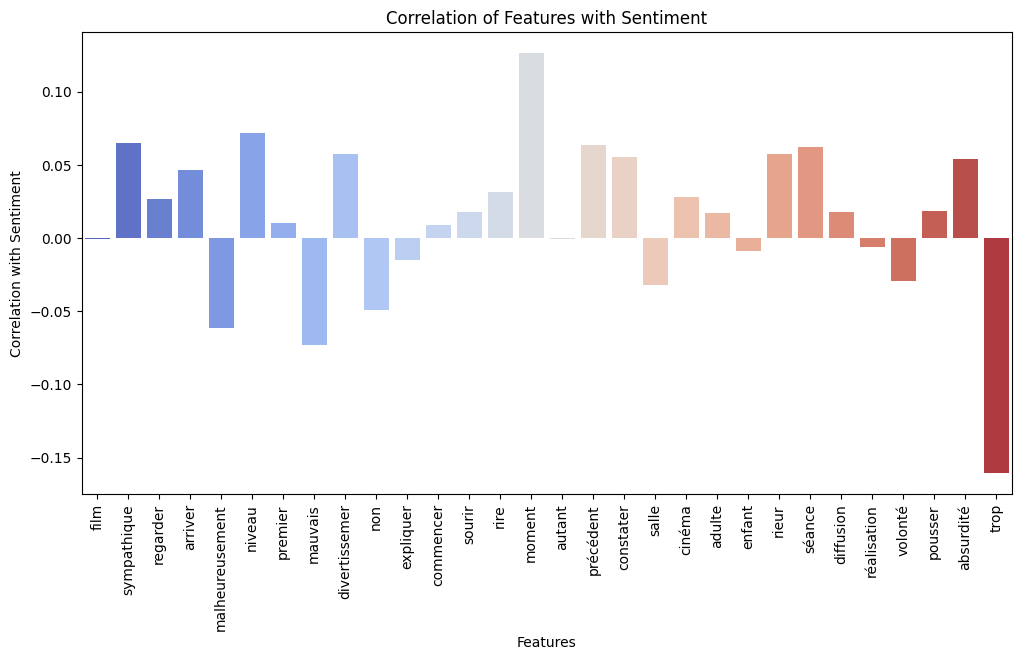

In [14]:
import seaborn as sns
# Compute correlation of all columns with __sentiment__
corr = df_words.corr()["__sentiment__"].drop("__sentiment__")

# Plot a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=corr.index, y=corr.values, palette="coolwarm")

# Rotate x labels for readability
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Correlation with Sentiment")
plt.title("Correlation of Features with Sentiment")

# Show the plot
plt.show()


**Interprétation :**
- Corrélation forte (positive ou négative) : Le mot est important pour le sentiment.
- Corrélation faible ou proche de 0 : Le mot ne pèse pas beaucoup sur le sentiment.

On peut utiliser cette analyse pour supprimer les mots peu influents (faible corrélation) du modèle afin d'améliorer la classification.

In [15]:
corr.describe()

count    30.000000
mean      0.013273
std       0.054529
min      -0.160588
25%      -0.008017
50%       0.017915
75%       0.055109
max       0.126331
Name: __sentiment__, dtype: float64

In [16]:
# Idée : Supprimer les mots dont la corrélation est proche du 50ᵉ percentile (médiane)
corr.describe()["50%"]

0.01791476332417319

**Mon Avis :**
L'idée de supprimer les mots dont la corrélation est proche de 0 peut être utile si on veut réduire la complexité du modèle en éliminant les mots qui n'ont pas une forte influence sur le sentiment.

**Pourquoi c'est pertinent ?**
Les mots dont la corrélation est proche de 0 ne contribuent pas fortement à la classification du sentiment.
En supprimant ces mots, on garde uniquement les mots vraiment influents (ceux ayant une forte corrélation positive ou négative).

**Mais attention :**
Parfois, même des mots à corrélation moyenne peuvent être utiles en combinaison avec d'autres, même si un modèle basé sur la vectorisation `TF-IDF` ne pourra pas gérer le contexte sémantique. 

**On pourrait aussi evaluer l'impact des mots après l'entrainement du modèle mais cela serait trop coûteux !**

### Sur tout le dataset train

In [18]:
del df
df = data['train']
cleaned_contenus = []
for i in tqdm(range(df.shape[0])):
    cleaned_contenus.append(preprocess(df['contenu'].iloc[i]))
df['cleaned_contenu'] = cleaned_contenus

  3%|▎         | 1579/56329 [00:41<23:44, 38.42it/s]


KeyboardInterrupt: 

In [ ]:
def wordBalancedOnSentiment(df : pd.DataFrame):
    words_count = {} 
    for j in tqdm(range(df.shape[0])):
        words = df['cleaned_contenu'].iloc[j].lower().split() # the already preprocess one 
        for word in words:
            if word not in words_count:
                words_count[word] = [0 for _ in range(df.shape[0])]
            words_count[word][j] += 1

    words_count['__sentiment__'] = df['sentiment'].copy()
    return words_count

In [ ]:
# on fait sur tout les mots
words_count = wordBalancedOnSentiment(df)

100%|██████████| 500/500 [00:00<00:00, 3579.15it/s]


In [ ]:
def computeCorr(words_count : dict):
    corr = {}
    for word in tqdm(words_count.keys()):
        if word == '__sentiment__':
            continue 
        current_corr = pd.DataFrame({
            '__sentiment__' : words_count['__sentiment__'].copy(),
            word : words_count[word]
        }).corr()["__sentiment__"].drop("__sentiment__")
        corr[word] = [current_corr[word]]
  
    return pd.DataFrame(corr).T

In [ ]:
corr = computeCorr(words_count)
corr.head()

100%|██████████| 6523/6523 [00:07<00:00, 915.66it/s] 


,0
film,-0.006431
sympathique,0.051335
regarder,0.025170
arrive,0.035862
malheureusement,-0.061652


<Axes: >

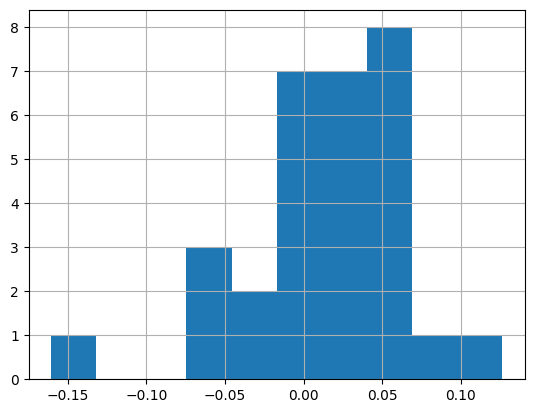

In [20]:
# distribution 
corr.hist()

In [21]:
corr.describe()

count    30.000000
mean      0.013273
std       0.054529
min      -0.160588
25%      -0.008017
50%       0.017915
75%       0.055109
max       0.126331
Name: __sentiment__, dtype: float64

In [ ]:
def is_useless(corr_value, esp=1e-3):
    return corr_value >= - esp  and corr_value <= esp

- creation preprocess finale
- tf-idf + LogisticRegression
- best model
- evaluation 
- save

- camembert + ffnlayer
- evaluation 
- save

- comparaions 
- use case
- rapport
- ppt
- video